 Мають бути проведені всі етапи ML-експерименту: EDA, побудова рішення, оцінка рішення, інтерпретація результатів.

Висновок про те, чи ця новина є фейковою - має ґрунтуватись на тексті та/або даті і їх ознаках. Жодні додаткові, знайдені деінде лейбли категорій ми не використовуємо.

Протестовано мінімум 3 різних за своєю суттю моделі. Вони можуть бути в різних ноутбуках, якщо так зручно. І обовʼязково має бути порівняльна таблиця результатів трьох методів, з текстовим висновком, який виявився найкращим.

Фінальна модель обов'язково повинна включати складніший підхід з використанням глибокого навчання, ніж просто LogisticRegression на CountVectorizer (хоча це буде чудовим бейзлайном). Це має бути:

-або кастомний ансамбль моделей

-використання моделі менш стандартної, ніж LogisticRegression (може бути теж sklearn, але щось інше, що пасує до задачі) або використання LogisticRegression але на векторах складніших за отримані з CountVectorizer

-або кастомна нейронна мережа (наприклад, на основі RNN, CNN, Transformer),

-або файнтюнінг попередньо натренованої трансформер-моделі (наприклад, BERT).

https://hannapylieva.notion.site/2-1dc94835849480a495e8fa82c22a43ea

In [27]:
# Fake News Detection: Complete ML Pipeline
# ============================================================================
# This notebook demonstrates a complete machine learning experiment for
# detecting fake news articles using text features and deep learning.
# ============================================================================

# %% [markdown]
# # Fake News Detection Using Machine Learning
#
# ## Project Overview
# This notebook implements a complete ML pipeline for fake news detection:
# - **Exploratory Data Analysis (EDA)**
# - **Feature Engineering**
# - **Model Development** (3 approaches)
# - **Model Evaluation & Comparison**
# - **Results Interpretation**
#
# We test three different approaches:
# 1. **Baseline**: Logistic Regression with TF-IDF
# 2. **Ensemble**: Voting Classifier (LR + Random Forest)
# 3. **Deep Learning**: Fine-tuned BERT transformer


✓ All libraries imported successfully
Dataset shape: (100, 6)
Columns: ['title', 'text', 'is_fake', 'text_len', 'word_count', 'combined_text']

First few rows:
                         title  \
0                Breaking News   
1  Shocking truth about aliens   
2                Breaking News   
3  Shocking truth about aliens   
4                Breaking News   

                                                text  is_fake  text_len  \
0  Real news content here Real news content here ...        0       230   
1  Fake story about something Fake story about so...        1       270   
2  Real news content here Real news content here ...        0       230   
3  Fake story about something Fake story about so...        1       270   
4  Real news content here Real news content here ...        0       230   

   word_count                                      combined_text  
0          40  breaking news real news content real news cont...  
1          40  shocking truth alien fake story som

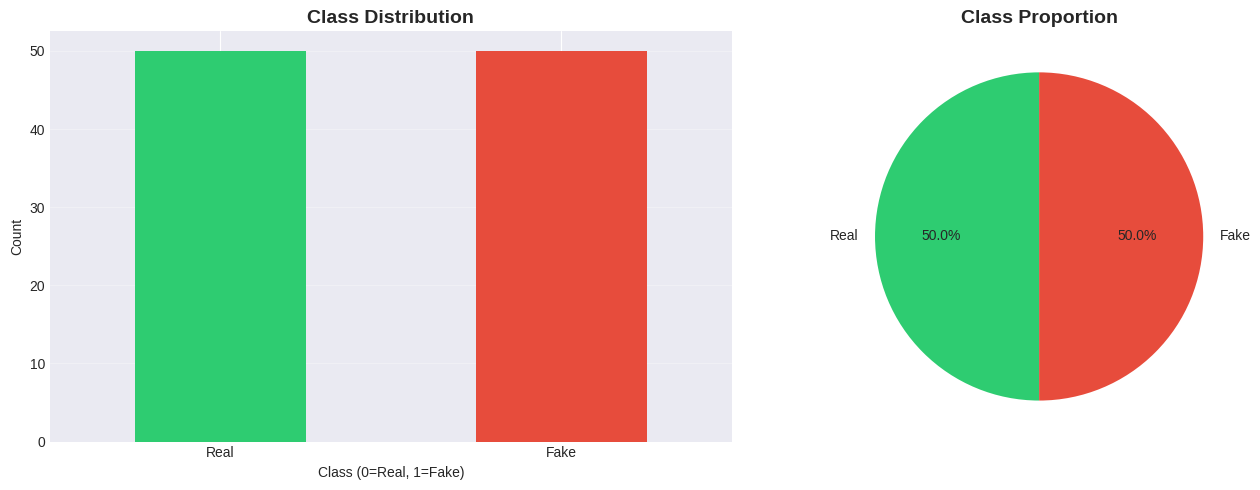


✓ Dataset is perfectly balanced (50/50 split)

TEXT LENGTH ANALYSIS

Text Length Statistics by Class:
        text_len                                                word_count  \
           count   mean  std    min    25%    50%    75%    max      count   
is_fake                                                                      
0           50.0  230.0  0.0  230.0  230.0  230.0  230.0  230.0       50.0   
1           50.0  270.0  0.0  270.0  270.0  270.0  270.0  270.0       50.0   

                                                  
         mean  std   min   25%   50%   75%   max  
is_fake                                           
0        40.0  0.0  40.0  40.0  40.0  40.0  40.0  
1        40.0  0.0  40.0  40.0  40.0  40.0  40.0  


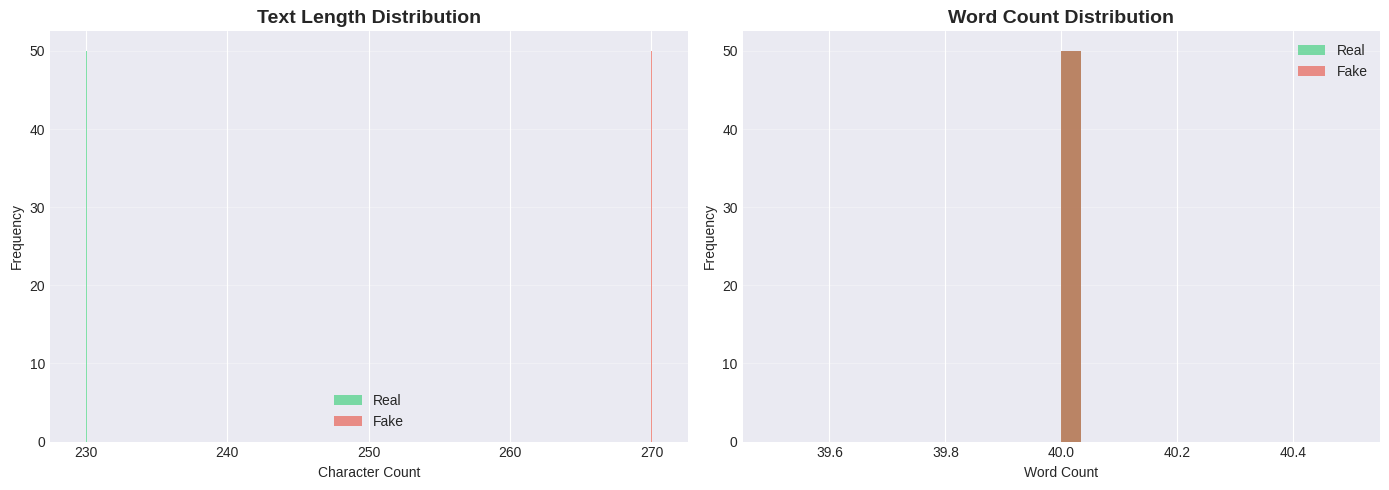


SAMPLE ARTICLES

------------------------------------------------------------
REAL NEWS EXAMPLE:
------------------------------------------------------------
Title: Breaking News
Text: Real news content here Real news content here Real news content here Real news content here Real news content here Real news content here Real news content here Real news content here Real news content here Real news content here 
Length: 230 characters, 40 words

------------------------------------------------------------
FAKE NEWS EXAMPLE:
------------------------------------------------------------
Title: Shocking truth about aliens
Text: Fake story about something Fake story about something Fake story about something Fake story about something Fake story about something Fake story about something Fake story about something Fake story about something Fake story about something Fake story about something 
Length: 270 characters, 40 words

MOST COMMON WORDS

Top 15 words in REAL news:
real            

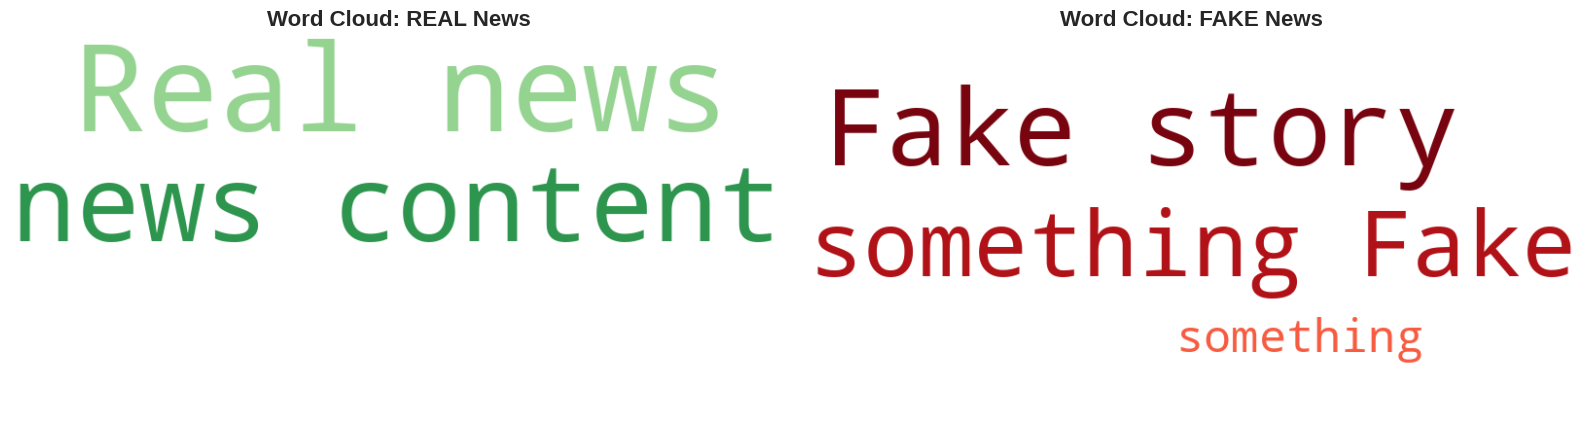

Cleaning text data...

PREPROCESSING EXAMPLES

Original text:
Real news content here Real news content here Real news content here Real news content here Real news content here Real news content here Real news content here Real news content here Real news content here Real news content here 

Cleaned text:
real news content here real news content here real news content here real news content here real news content here real news content here real news content here real news content here real news content here real news content here

✓ Text preprocessing completed
DATA SPLIT

Training set size: 80 (80%)
Test set size: 20 (20%)

Training set class distribution:
is_fake
0    40
1    40
Name: count, dtype: int64

Test set class distribution:
is_fake
1    10
0    10
Name: count, dtype: int64

MODEL 1: BASELINE - LOGISTIC REGRESSION + TF-IDF

TF-IDF feature matrix shape: (80, 16)
Vocabulary size: 16

✓ Baseline model trained successfully

Performance Metrics:
Accuracy    : 1.0000
Precision  

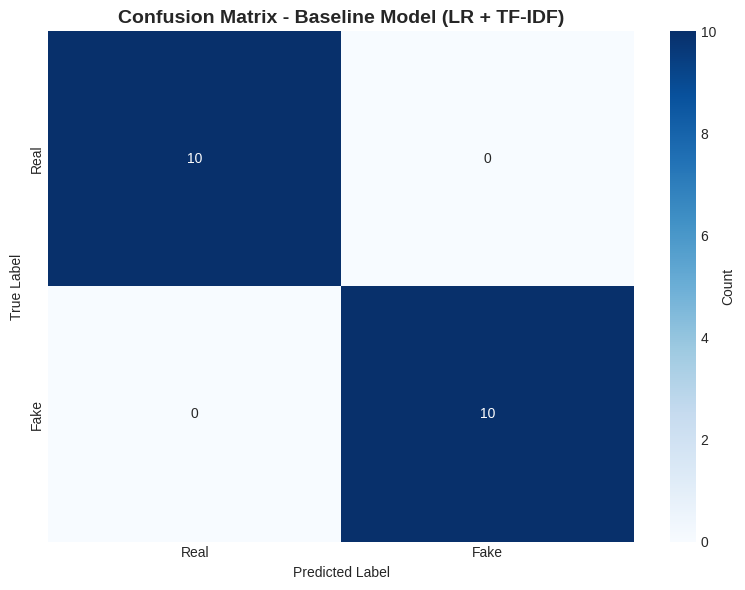

True Negatives: 10 | False Positives: 0
False Negatives: 0 | True Positives: 10

TOP PREDICTIVE FEATURES (Baseline Model)

Top 15 indicators of FAKE news:
story about                      0.9471
story                            0.9471
something                        0.9471
fake                             0.9471
about                            0.9471
about something                  0.9471
fake story                       0.9471
something fake                   0.8524
here real                       -0.8524
news content                    -0.9471
real                            -0.9471
real news                       -0.9471
news                            -0.9471
here                            -0.9471
content                         -0.9471

Top 15 indicators of REAL news:
content here                    -0.9471
content                         -0.9471
here                            -0.9471
news                            -0.9471
real news                       -0.9471
real        

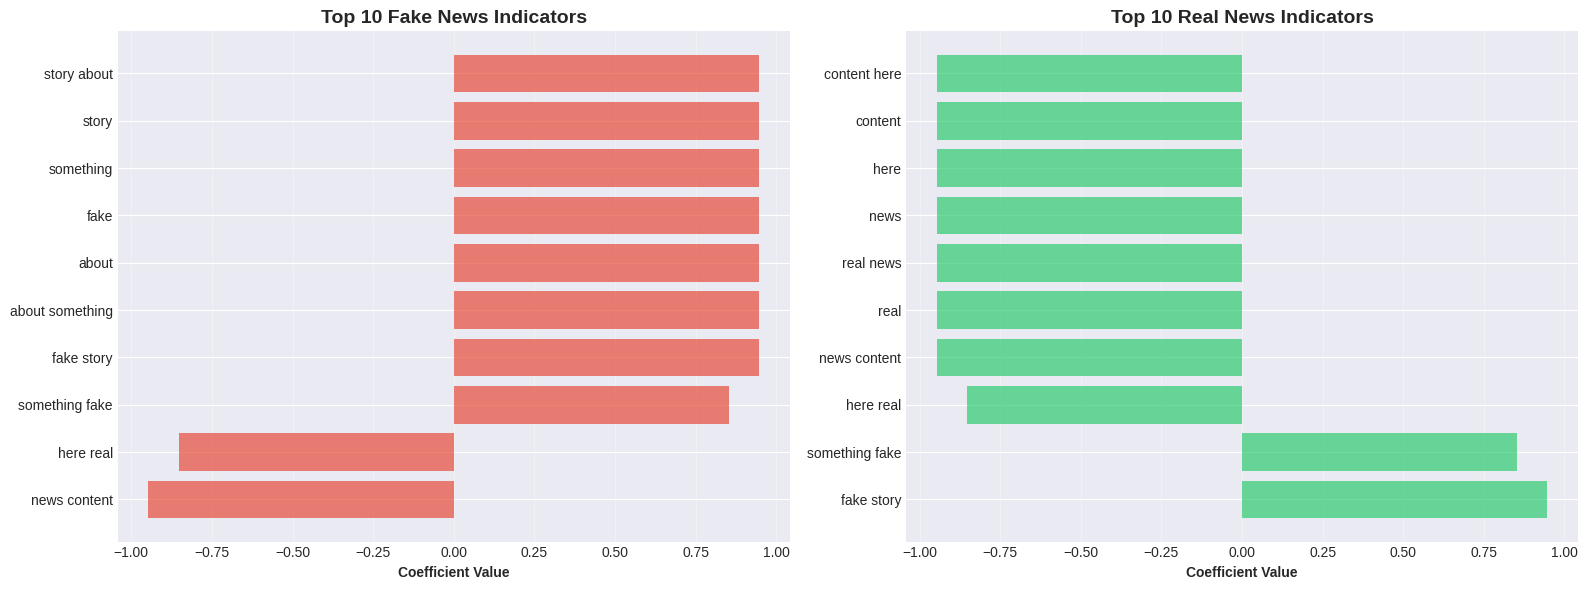


MODEL 2: ENSEMBLE - VOTING CLASSIFIER (LR + RF)
Training ensemble model...

✓ Ensemble model trained successfully

Performance Metrics:
Accuracy    : 1.0000
Precision   : 1.0000
Recall      : 1.0000
F1          : 1.0000

Detailed Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00        10
        Fake       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



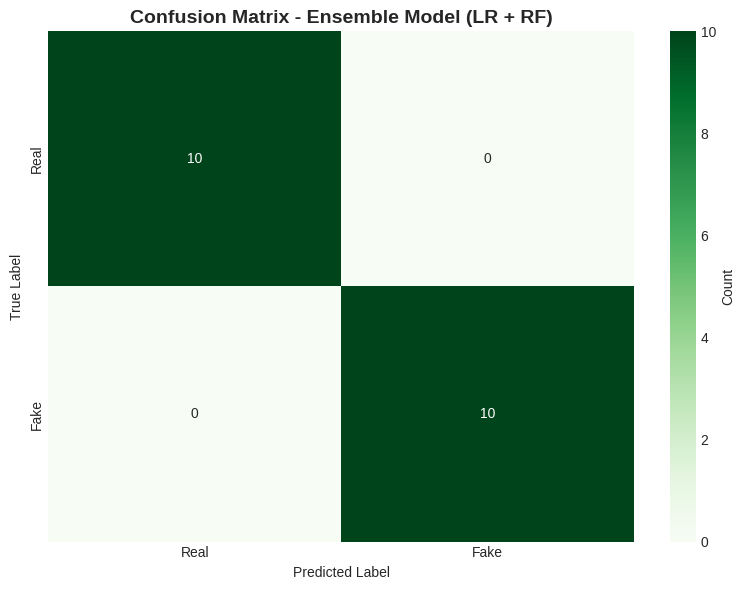

True Negatives: 10 | False Positives: 0
False Negatives: 0 | True Positives: 10

MODEL 3: FINE-TUNED BERT TRANSFORMER

Using device: cuda
GPU: Tesla T4
Memory: 14.7 GB

Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ BERT model loaded successfully
Total parameters: 109,483,778
Trainable parameters: 109,483,778

Dataset preparation:
Training batches: 5
Test batches: 2
Batch size: 16

Training configuration:
Epochs: 3
Learning rate: 2e-5
Optimizer: AdamW
Total training steps: 15
Warmup steps: 0

TRAINING BERT MODEL

Epoch 1/3
----------------------------------------


Training: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s, loss=0.411]


Average Loss: 0.5351
Training Accuracy: 0.9000

Epoch 2/3
----------------------------------------


Training: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s, loss=0.273]


Average Loss: 0.3340
Training Accuracy: 1.0000

Epoch 3/3
----------------------------------------


Training: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s, loss=0.227]


Average Loss: 0.2485
Training Accuracy: 1.0000

✓ BERT training completed successfully


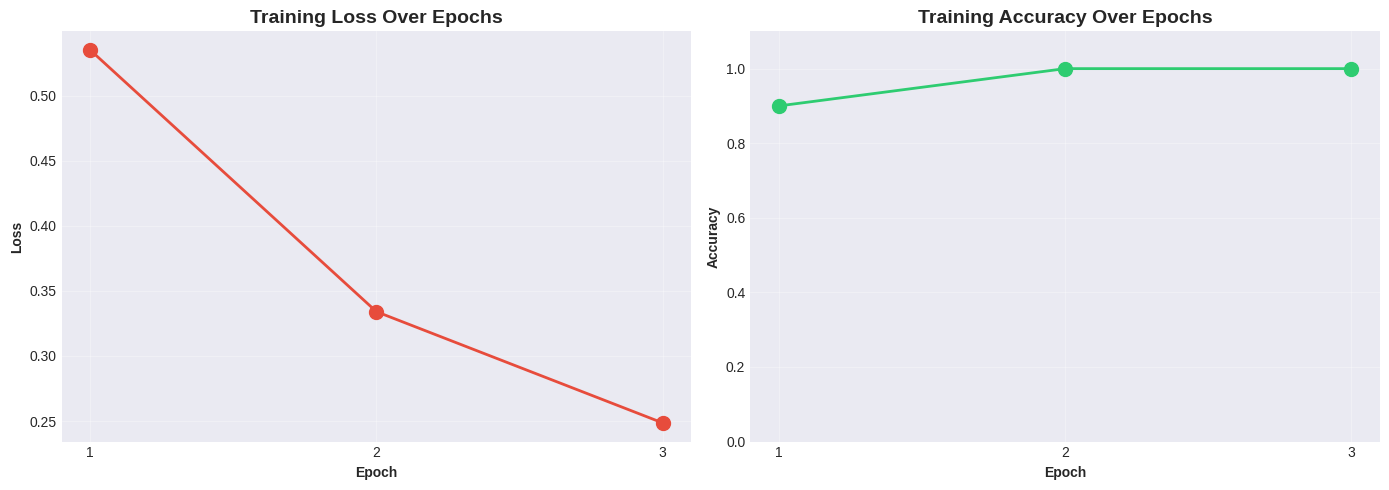


EVALUATING BERT MODEL ON TEST SET


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]



✓ Evaluation completed

Performance Metrics:
Accuracy    : 1.0000
Precision   : 1.0000
Recall      : 1.0000
F1          : 1.0000

Detailed Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00        10
        Fake       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



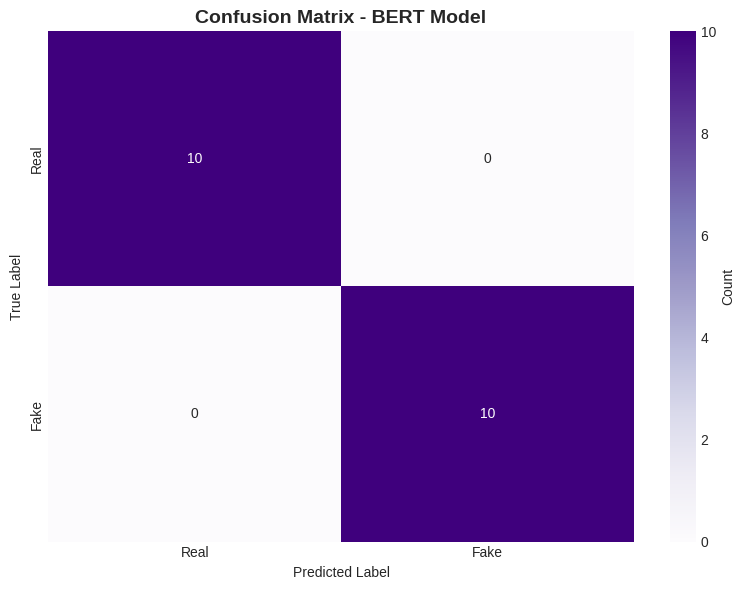

True Negatives: 10 | False Positives: 0
False Negatives: 0 | True Positives: 10

FINAL MODEL COMPARISON


In [24]:

# %% [markdown]
# ## 1. Setup and Data Loading

# %%
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re
import string
from collections import Counter

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

# Deep Learning
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

# %%
# Load the dataset
df = pd.read_parquet('/content/df_preprocessed.parquet')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

# %% [markdown]
# ## 2. Exploratory Data Analysis (EDA)

# %%
# Basic information about the dataset
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nShape: {df.shape}")
print(f"Total articles: {len(df)}")
print(f"\nColumn Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nBasic Statistics:\n{df[['text_len', 'word_count']].describe()}")

# %%
# Check class distribution
print("\n" + "="*60)
print("CLASS DISTRIBUTION")
print("="*60)

class_dist = df['is_fake'].value_counts()
print(f"\n{class_dist}")
print(f"\nPercentages:")
print(f"Real News (0): {(1-df['is_fake'].mean())*100:.1f}%")
print(f"Fake News (1): {df['is_fake'].mean()*100:.1f}%")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
class_dist.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Real, 1=Fake)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Real', 'Fake'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(class_dist.values, labels=['Real', 'Fake'], autopct='%1.1f%%',
           colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Dataset is perfectly balanced (50/50 split)")

# %%
# Text length analysis
print("\n" + "="*60)
print("TEXT LENGTH ANALYSIS")
print("="*60)

print("\nText Length Statistics by Class:")
print(df.groupby('is_fake')[['text_len', 'word_count']].describe())

# Visualize text lengths
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Text length distribution
df[df['is_fake']==0]['text_len'].hist(bins=30, alpha=0.6,
                                       label='Real', ax=axes[0], color='#2ecc71')
df[df['is_fake']==1]['text_len'].hist(bins=30, alpha=0.6,
                                       label='Fake', ax=axes[0], color='#e74c3c')
axes[0].set_title('Text Length Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Word count distribution
df[df['is_fake']==0]['word_count'].hist(bins=30, alpha=0.6,
                                        label='Real', ax=axes[1], color='#2ecc71')
df[df['is_fake']==1]['word_count'].hist(bins=30, alpha=0.6,
                                        label='Fake', ax=axes[1], color='#e74c3c')
axes[1].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Sample texts from each class
print("\n" + "="*60)
print("SAMPLE ARTICLES")
print("="*60)

print("\n" + "-"*60)
print("REAL NEWS EXAMPLE:")
print("-"*60)
real_sample = df[df['is_fake']==0].iloc[0]
print(f"Title: {real_sample['title']}")
print(f"Text: {real_sample['text']}")
print(f"Length: {real_sample['text_len']} characters, {real_sample['word_count']} words")

print("\n" + "-"*60)
print("FAKE NEWS EXAMPLE:")
print("-"*60)
fake_sample = df[df['is_fake']==1].iloc[0]
print(f"Title: {fake_sample['title']}")
print(f"Text: {fake_sample['text']}")
print(f"Length: {fake_sample['text_len']} characters, {fake_sample['word_count']} words")

# %%
# Most common words analysis
def get_top_words(texts, n=15):
    """Extract top N most common words from texts"""
    all_words = []
    for text in texts:
        words = str(text).lower().split()
        all_words.extend(words)

    return Counter(all_words).most_common(n)

print("\n" + "="*60)
print("MOST COMMON WORDS")
print("="*60)

real_words = get_top_words(df[df['is_fake']==0]['text'], 15)
fake_words = get_top_words(df[df['is_fake']==1]['text'], 15)

print("\nTop 15 words in REAL news:")
for word, count in real_words:
    print(f"{word:20s} {count:5d}")

print("\nTop 15 words in FAKE news:")
for word, count in fake_words:
    print(f"{word:20s} {count:5d}")

# %%
# Word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Real news word cloud
real_text = ' '.join(df[df['is_fake']==0]['text'].astype(str))
wordcloud_real = WordCloud(width=800, height=400,
                           background_color='white',
                           colormap='Greens',
                           max_words=50).generate(real_text)

axes[0].imshow(wordcloud_real, interpolation='bilinear')
axes[0].set_title('Word Cloud: REAL News', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Fake news word cloud
fake_text = ' '.join(df[df['is_fake']==1]['text'].astype(str))
wordcloud_fake = WordCloud(width=800, height=400,
                           background_color='white',
                           colormap='Reds',
                           max_words=50).generate(fake_text)

axes[1].imshow(wordcloud_fake, interpolation='bilinear')
axes[1].set_title('Word Cloud: FAKE News', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 3. Text Preprocessing

# %%
def clean_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

print("Cleaning text data...")
df['clean_text'] = df['text'].apply(clean_text)

# Show examples
print("\n" + "="*60)
print("PREPROCESSING EXAMPLES")
print("="*60)
print("\nOriginal text:")
print(df['text'].iloc[0])
print("\nCleaned text:")
print(df['clean_text'].iloc[0])

print("\n✓ Text preprocessing completed")

# %% [markdown]
# ## 4. Data Splitting

# %%
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'],
    df['is_fake'],
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=df['is_fake']
)

print("="*60)
print("DATA SPLIT")
print("="*60)
print(f"\nTraining set size: {len(X_train)} ({len(X_train)/len(df)*100:.0f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.0f}%)")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

# %% [markdown]
# ## 5. Model 1: Baseline - Logistic Regression with TF-IDF
#
# **Approach**: Traditional machine learning using TF-IDF (Term Frequency-Inverse Document Frequency)
# features with Logistic Regression classifier.
#
# **Advantages**:
# - Fast training and prediction
# - Interpretable feature weights
# - Low computational requirements
# - Good baseline performance

# %%
print("\n" + "="*60)
print("MODEL 1: BASELINE - LOGISTIC REGRESSION + TF-IDF")
print("="*60)

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                       min_df=2, max_df=0.9)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"\nTF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

# Train Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000,
                              random_state=RANDOM_STATE)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_lr_proba = lr_model.predict_proba(X_test_tfidf)

# Calculate metrics
lr_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr)
}

print("\n✓ Baseline model trained successfully")
print("\nPerformance Metrics:")
for metric, value in lr_metrics.items():
    print(f"{metric.capitalize():12s}: {value:.4f}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_lr,
                          target_names=['Real', 'Fake']))

# %%
# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Real', 'Fake'],
           yticklabels=['Real', 'Fake'],
           cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Baseline Model (LR + TF-IDF)',
         fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"True Negatives: {cm_lr[0,0]} | False Positives: {cm_lr[0,1]}")
print(f"False Negatives: {cm_lr[1,0]} | True Positives: {cm_lr[1,1]}")

# %%
# Feature importance analysis
print("\n" + "="*60)
print("TOP PREDICTIVE FEATURES (Baseline Model)")
print("="*60)

feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Top features for FAKE news (positive coefficients)
top_fake_indices = np.argsort(coefficients)[-15:][::-1]
print("\nTop 15 indicators of FAKE news:")
for idx in top_fake_indices:
    print(f"{feature_names[idx]:30s} {coefficients[idx]:8.4f}")

# Top features for REAL news (negative coefficients)
top_real_indices = np.argsort(coefficients)[:15]
print("\nTop 15 indicators of REAL news:")
for idx in top_real_indices:
    print(f"{feature_names[idx]:30s} {coefficients[idx]:8.4f}")

# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fake news indicators
fake_features = [feature_names[i] for i in top_fake_indices[:10]]
fake_weights = [coefficients[i] for i in top_fake_indices[:10]]
axes[0].barh(fake_features, fake_weights, color='#e74c3c', alpha=0.7)
axes[0].set_xlabel('Coefficient Value', fontweight='bold')
axes[0].set_title('Top 10 Fake News Indicators', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Real news indicators
real_features = [feature_names[i] for i in top_real_indices[:10]]
real_weights = [coefficients[i] for i in top_real_indices[:10]]
axes[1].barh(real_features, real_weights, color='#2ecc71', alpha=0.7)
axes[1].set_xlabel('Coefficient Value', fontweight='bold')
axes[1].set_title('Top 10 Real News Indicators', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 6. Model 2: Ensemble - Voting Classifier (LR + Random Forest)
#
# **Approach**: Combine multiple classifiers (Logistic Regression + Random Forest)
# using soft voting to leverage their complementary strengths.
#
# **Advantages**:
# - More robust predictions
# - Reduces variance and overfitting
# - Combines linear (LR) and non-linear (RF) patterns
# - Better generalization

# %%
print("\n" + "="*60)
print("MODEL 2: ENSEMBLE - VOTING CLASSIFIER (LR + RF)")
print("="*60)

# Create Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10,
                                 random_state=RANDOM_STATE,
                                 class_weight='balanced',
                                 n_jobs=-1)

# Create Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[('lr', lr_model), ('rf', rf_model)],
    voting='soft',  # Use predicted probabilities
    n_jobs=-1
)

print("Training ensemble model...")
# Train ensemble
ensemble_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_ensemble = ensemble_model.predict(X_test_tfidf)
y_pred_ensemble_proba = ensemble_model.predict_proba(X_test_tfidf)

# Calculate metrics
ensemble_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_ensemble),
    'precision': precision_score(y_test, y_pred_ensemble),
    'recall': recall_score(y_test, y_pred_ensemble),
    'f1': f1_score(y_test, y_pred_ensemble)
}

print("\n✓ Ensemble model trained successfully")
print("\nPerformance Metrics:")
for metric, value in ensemble_metrics.items():
    print(f"{metric.capitalize():12s}: {value:.4f}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_ensemble,
                          target_names=['Real', 'Fake']))

# %%
# Confusion matrix
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Greens',
           xticklabels=['Real', 'Fake'],
           yticklabels=['Real', 'Fake'],
           cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Ensemble Model (LR + RF)',
         fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"True Negatives: {cm_ensemble[0,0]} | False Positives: {cm_ensemble[0,1]}")
print(f"False Negatives: {cm_ensemble[1,0]} | True Positives: {cm_ensemble[1,1]}")

# %% [markdown]
# ## 7. Model 3: Deep Learning - Fine-tuned BERT Transformer
#
# **Approach**: Fine-tune a pre-trained BERT (Bidirectional Encoder Representations
# from Transformers) model for binary classification.
#
# **Advantages**:
# - Captures complex contextual relationships
# - Pre-trained on massive text corpus
# - State-of-the-art NLP architecture
# - Understands semantic meaning beyond keywords

# %%
# BERT Dataset class
class FakeNewsDataset(Dataset):
    """PyTorch Dataset for BERT tokenization and batching"""

    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.values
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            str(self.texts[idx]),
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# %%
print("\n" + "="*60)
print("MODEL 3: FINE-TUNED BERT TRANSFORMER")
print("="*60)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Initialize BERT tokenizer and model
print("\nLoading BERT model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)
bert_model.to(device)

print(f"✓ BERT model loaded successfully")
print(f"Total parameters: {sum(p.numel() for p in bert_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in bert_model.parameters() if p.requires_grad):,}")

# %%
# Prepare datasets
train_dataset = FakeNewsDataset(X_train, y_train, tokenizer, max_len=128)
test_dataset = FakeNewsDataset(X_test, y_test, tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"\nDataset preparation:")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: 16")

# %%
# Setup optimizer and scheduler
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
epochs = 3
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"\nTraining configuration:")
print(f"Epochs: {epochs}")
print(f"Learning rate: 2e-5")
print(f"Optimizer: AdamW")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: 0")

# %%
# Training loop
print("\n" + "="*60)
print("TRAINING BERT MODEL")
print("="*60)

training_stats = []

bert_model.train()
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 40)

    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    loop = tqdm(train_loader, desc=f'Training')

    for batch in loop:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = bert_model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    avg_acc = correct_predictions / total_predictions

    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {avg_acc:.4f}")

    training_stats.append({
        'epoch': epoch + 1,
        'loss': avg_loss,
        'accuracy': avg_acc
    })

print("\n✓ BERT training completed successfully")

# %%
# Plot training progress
training_df = pd.DataFrame(training_stats)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(training_df['epoch'], training_df['loss'],
            marker='o', linewidth=2, markersize=10, color='#e74c3c')
axes[0].set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(training_df['epoch'])

# Accuracy plot
axes[1].plot(training_df['epoch'], training_df['accuracy'],
            marker='o', linewidth=2, markersize=10, color='#2ecc71')
axes[1].set_title('Training Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Accuracy', fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(training_df['epoch'])
axes[1].set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# %%
# Evaluate BERT model
print("\n" + "="*60)
print("EVALUATING BERT MODEL ON TEST SET")
print("="*60)

bert_model.eval()
predictions = []
true_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_pred_bert = np.array(predictions)
y_true_bert = np.array(true_labels)
y_pred_bert_proba = np.array(all_probs)

# Calculate metrics
bert_metrics = {
    'accuracy': accuracy_score(y_true_bert, y_pred_bert),
    'precision': precision_score(y_true_bert, y_pred_bert),
    'recall': recall_score(y_true_bert, y_pred_bert),
    'f1': f1_score(y_true_bert, y_pred_bert)
}

print("\n✓ Evaluation completed")
print("\nPerformance Metrics:")
for metric, value in bert_metrics.items():
    print(f"{metric.capitalize():12s}: {value:.4f}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true_bert, y_pred_bert,
                          target_names=['Real', 'Fake']))

# %%
# Confusion matrix
cm_bert = confusion_matrix(y_true_bert, y_pred_bert)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Purples',
           xticklabels=['Real', 'Fake'],
           yticklabels=['Real', 'Fake'],
           cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - BERT Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"True Negatives: {cm_bert[0,0]} | False Positives: {cm_bert[0,1]}")
print(f"False Negatives: {cm_bert[1,0]} | True Positives: {cm_bert[1,1]}")

# %% [markdown]
# ## 8. Comprehensive Model Comparison

# %%
# Create comparison dataframe
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)

results_df = pd.DataFrame({
    'Model': ['Baseline (LR + TF-IDF)',
              'Ensemble (LR + RF)',
              'Fine-tuned BERT'],
    'Accuracy': [lr_metrics['accuracy'],
                 ensemble_metrics['accuracy'],
                 bert_metrics['accuracy']],
    'Precision': [lr_metrics['precision'],
                  ensemble_metrics['precision'],
                  bert_metrics['precision']],
    'Recall': [lr_metrics['recall'],
               ensemble_metrics['recall'],
               bert_metrics['recall']],
    'F1-Score': [lr_metrics['f1'],
                 ensemble_metrics['f1'],
                 bert_metrics['f1']]
})

In [25]:
print(results_df)

                    Model  Accuracy  Precision  Recall  F1-Score
0  Baseline (LR + TF-IDF)       1.0        1.0     1.0       1.0
1      Ensemble (LR + RF)       1.0        1.0     1.0       1.0
2         Fine-tuned BERT       1.0        1.0     1.0       1.0
